# Imports & General

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [2]:
print("OK")

OK


In [3]:
base_path = '/content/drive/MyDrive/dmeyf/2024/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202101, 202102, 202103]
#mes_train = [202103]
mes_test = 202104

mes_train_all = [202101, 202102, 202103,202104]
mes_futuro = 202106


semillas = [100992,140795,130316,130351,130255]

In [4]:
bucket_name = "brianlitwak_bukito3"  # Reemplaza con el nombre de tu bucket
file_path = f"gs://{bucket_name}/datasets/competencia_01.csv"
# Leer el CSV
df = pd.read_csv(file_path)

/tmp/ipykernel_7198/3351902583.py:4: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
df.head(2)

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria
0,249221323,202101,1,0,0,46,93,3070.24,15691.1,1278.11,...,4.0,0.00,-20833.47,0.0,2814.0,6743.38,6.0,0.0,9559.95,CONTINUA
1,249227600,202101,1,0,0,42,278,496.21,15321.8,418.97,...,11.0,13267.49,-9662.51,0.0,5541.0,9419.90,8.0,0.0,1900.26,CONTINUA


In [6]:
#df['target'] = (df['clase_ternaria'] == 'BAJA+2').astype('int8')
df["target"] = df["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]).astype("int8")
df['clase_peso'] = 1.0

In [7]:

import pandas as pd
import numpy as np

# Asegurar orden temporal
df = df.sort_values(['foto_mes', 'numero_de_cliente']).reset_index(drop=True)

# Detectar columnas numéricas que no son ID ni target
num_cols = [
    c for c in df.columns
    if c not in ['numero_de_cliente', 'foto_mes', 'clase_ternaria', 'target','clase_peso']
    and pd.api.types.is_numeric_dtype(df[c])
]


# Función auxiliar: asigna centil por grupo
def to_percentile(series):
    # rank(pct=True) da un rango [0,1] → lo escalamos a 0–100
    return (series.rank(pct=True) * 100).astype(np.float32)

# Aplicar por mes y reemplazar
for c in num_cols:
    new_col = f'{c}_pctl'
    df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)
    df.drop(columns=[c], inplace=True)  # eliminar la original
    print(f"✅ Convertida {c} → {new_col}")

print(f"\nTotal columnas convertidas: {len(num_cols)}")


✅ Convertida active_quarter → active_quarter_pctl
✅ Convertida cliente_vip → cliente_vip_pctl
✅ Convertida internet → internet_pctl
✅ Convertida cliente_edad → cliente_edad_pctl
✅ Convertida cliente_antiguedad → cliente_antiguedad_pctl
✅ Convertida mrentabilidad → mrentabilidad_pctl
✅ Convertida mrentabilidad_annual → mrentabilidad_annual_pctl
✅ Convertida mcomisiones → mcomisiones_pctl
✅ Convertida mactivos_margen → mactivos_margen_pctl
✅ Convertida mpasivos_margen → mpasivos_margen_pctl
✅ Convertida cproductos → cproductos_pctl
✅ Convertida tcuentas → tcuentas_pctl
✅ Convertida ccuenta_corriente → ccuenta_corriente_pctl
✅ Convertida mcuenta_corriente_adicional → mcuenta_corriente_adicional_pctl
✅ Convertida mcuenta_corriente → mcuenta_corriente_pctl
✅ Convertida ccaja_ahorro → ccaja_ahorro_pctl
✅ Convertida mcaja_ahorro → mcaja_ahorro_pctl
✅ Convertida mcaja_ahorro_adicional → mcaja_ahorro_adicional_pctl
✅ Convertida mcaja_ahorro_dolares → mcaja_ahorro_dolares_pctl
✅ Convertida cdesc

/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ccajas_transacciones → ccajas_transacciones_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ccajas_consultas → ccajas_consultas_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ccajas_depositos → ccajas_depositos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ccajas_extracciones → ccajas_extracciones_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ccajas_otras → ccajas_otras_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida catm_trx → catm_trx_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida matm → matm_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida catm_trx_other → catm_trx_other_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida matm_other → matm_other_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida ctrx_quarter → ctrx_quarter_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida tmobile_app → tmobile_app_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida cmobile_app_trx → cmobile_app_trx_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_delinquency → Master_delinquency_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_status → Master_status_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mfinanciacion_limite → Master_mfinanciacion_limite_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_Fvencimiento → Master_Fvencimiento_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_Finiciomora → Master_Finiciomora_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_msaldototal → Master_msaldototal_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_msaldopesos → Master_msaldopesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_msaldodolares → Master_msaldodolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mconsumospesos → Master_mconsumospesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mconsumosdolares → Master_mconsumosdolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mlimitecompra → Master_mlimitecompra_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_madelantopesos → Master_madelantopesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_madelantodolares → Master_madelantodolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_fultimo_cierre → Master_fultimo_cierre_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mpagado → Master_mpagado_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mpagospesos → Master_mpagospesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mpagosdolares → Master_mpagosdolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_fechaalta → Master_fechaalta_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mconsumototal → Master_mconsumototal_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_cconsumos → Master_cconsumos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_cadelantosefectivo → Master_cadelantosefectivo_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Master_mpagominimo → Master_mpagominimo_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_delinquency → Visa_delinquency_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_status → Visa_status_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mfinanciacion_limite → Visa_mfinanciacion_limite_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_Fvencimiento → Visa_Fvencimiento_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_Finiciomora → Visa_Finiciomora_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_msaldototal → Visa_msaldototal_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_msaldopesos → Visa_msaldopesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_msaldodolares → Visa_msaldodolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mconsumospesos → Visa_mconsumospesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mconsumosdolares → Visa_mconsumosdolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mlimitecompra → Visa_mlimitecompra_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_madelantopesos → Visa_madelantopesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_madelantodolares → Visa_madelantodolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_fultimo_cierre → Visa_fultimo_cierre_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mpagado → Visa_mpagado_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mpagospesos → Visa_mpagospesos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mpagosdolares → Visa_mpagosdolares_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_fechaalta → Visa_fechaalta_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mconsumototal → Visa_mconsumototal_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_cconsumos → Visa_cconsumos_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_cadelantosefectivo → Visa_cadelantosefectivo_pctl


/tmp/ipykernel_7198/2277465782.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df.groupby('foto_mes')[c].transform(to_percentile)


✅ Convertida Visa_mpagominimo → Visa_mpagominimo_pctl

Total columnas convertidas: 152


In [8]:
# === Lags/Deltas por cliente ===

df = df.sort_values(['numero_de_cliente','foto_mes']).reset_index(drop=True)

fe_cols = [c for c in df.columns
           if c not in ['numero_de_cliente','foto_mes','clase_ternaria','target','clase_peso']
           and pd.api.types.is_numeric_dtype(df[c])]

#for c in fe_cols:
#    lag = df.groupby('numero_de_cliente')[c].shift(1)
#    df[f'{c}_lag1']  = lag
#    df[f'{c}_dlag1'] = df[c] - lag

for c in fe_cols:
    for n in [1, 2]:  # cantidad de meses que querés mirar atrás
#    for n in [1, 2, 3]:  # cantidad de meses que querés mirar atrás
        lag = df.groupby('numero_de_cliente')[c].shift(n)
        df[f'{c}_lag{n}']  = lag
        df[f'{c}_dlag{n}'] = df[c] - lag

#df[ [f'{c}_lag1' for c in fe_cols] ] = df[ [f'{c}_lag1' for c in fe_cols] ].fillna(0.0)
#df[ [f'{c}_dlag1' for c in fe_cols] ] = df[ [f'{c}_dlag1' for c in fe_cols] ].fillna(0.0)

print("Lags/deltas agregados:", len(fe_cols)*2)


/tmp/ipykernel_7198/3416244142.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_dlag{n}'] = df[c] - lag
/tmp/ipykernel_7198/3416244142.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_lag{n}']  = lag
/tmp/ipykernel_7198/3416244142.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.c

Lags/deltas agregados: 304


/tmp/ipykernel_7198/3416244142.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_lag{n}']  = lag
/tmp/ipykernel_7198/3416244142.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_dlag{n}'] = df[c] - lag
/tmp/ipykernel_7198/3416244142.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.c

In [9]:
df['clase_peso'] = 1.0
df.loc[df['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df.loc[df['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

train_data = df[df['foto_mes'].isin(mes_train)]
test_data = df[df['foto_mes'] == mes_test]
kaggle_data = df[df['foto_mes'] == mes_futuro]
X_kaggle_data = kaggle_data.drop(['clase_ternaria', 'target', 'clase_peso'], axis=1)#

mes_train_all_data = df[df['foto_mes'].isin(mes_train_all)]
X_train_all_data = mes_train_all_data.drop(['clase_ternaria', 'target', 'clase_peso'], axis=1)#
X_train_all_binaria = mes_train_all_data['target']
w_train_all = mes_train_all_data['clase_peso']


X_train = train_data.drop(['clase_ternaria', 'target', 'clase_peso'], axis=1)#
y_train_binaria1 = train_data['target']
w_train = train_data['clase_peso']


X_test = test_data.drop(['clase_ternaria', 'target', 'clase_peso'], axis=1)#, 'clase_peso'
y_test_binaria1 = test_data['target']
w_test = test_data['clase_peso']


In [10]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

# Test A

In [11]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),
    num_iterations = trial.suggest_int('num_iterations', 50, 1000),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria1, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=400, # modificar, subit y subir... y descomentar la línea inferior
        #early_stopping_rounds= int(50 + 5 / learning_rate),
        #num_boost_round=num_iterations,  # ← usamos el valor del trial
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///optimization_lgbm.db"
study_name = "exp_524_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-12 19:24:14,978] Using an existing study with name 'exp_524_lgbm' instead of creating a new one.


In [13]:
#study.optimize(objective, n_trials=20) # 808.180.000


In [14]:
#optuna.visualization.plot_optimization_history(study)

In [16]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop
#print("Ganancia LGBM:", ganancia_prob(y_pred_lgm, y_test_binaria1))
#Ganancia LGBM con historia: $878,000,000
#Ganancia RF: $322,460,000
#Ganancia LGBM: $326,140,000

# Test B varias semillas

In [17]:
study.best_trial.params

{'num_leaves': 100,
 'learning_rate': 0.09686090489702351,
 'min_data_in_leaf': 968,
 'feature_fraction': 0.7260430649166694,
 'bagging_fraction': 0.6426831876822654,
 'num_iterations': 994}

In [18]:
import pandas as pd
import lightgbm as lgb
import numpy as np

# 1️⃣ Hiperparámetros óptimos desde Optuna
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles (num_boost_round) = {best_iter}")

best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'verbose': -1
}

# 2️⃣ Entrenar modelos con distintas semillas
seeds = [100992, 140795, 130316, 130351, 130255]

# DataFrame base con el ID del cliente (asumiendo que X_test tiene esa columna)
df_preds = pd.DataFrame()
df_preds["numero_de_cliente"] = X_kaggle_data["numero_de_cliente"].values  # 👈 ajustá si tu ID tiene otro nombre

for seed in seeds:
    print(f"Entrenando modelo con semilla {seed} ...")
    params = best_params.copy()
    params['seed'] = seed

    # Dataset de entrenamiento
    train_data = lgb.Dataset(
        X_train_all_data,
        label=X_train_all_binaria,
        weight=w_train_all  # opcional
    )

    # Entrenar el modelo
    model = lgb.train(params, train_data, num_boost_round=best_iter)

    # Predecir
    preds = model.predict(X_kaggle_data)

    # Guardar columna con las predicciones de esta semilla
    df_preds[f"pred_seed_{seed}"] = preds

# 3️⃣ Promediar las columnas
df_preds["pred_mean"] = df_preds[[f"pred_seed_{s}" for s in seeds]].mean(axis=1)

print("✅ Ensemble final guardado en DataFrame.")
df_preds.head()


Mejor cantidad de árboles (num_boost_round) = 193
Entrenando modelo con semilla 100992 ...
Entrenando modelo con semilla 140795 ...
Entrenando modelo con semilla 130316 ...
Entrenando modelo con semilla 130351 ...
Entrenando modelo con semilla 130255 ...
✅ Ensemble final guardado en DataFrame.


,numero_de_cliente,pred_seed_100992,pred_seed_140795,pred_seed_130316,pred_seed_130351,pred_seed_130255,pred_mean
0,249221323,0.000015,0.000024,0.000049,0.000073,0.000013,0.000035
1,249227600,0.000179,0.000344,0.000230,0.000054,0.000053,0.000172
2,249234235,0.046125,0.029242,0.016950,0.062857,0.023099,0.035655
3,249244449,0.000565,0.001191,0.001814,0.001447,0.001405,0.001284
4,249244739,0.001430,0.004493,0.000179,0.001611,0.002779,0.002099


In [19]:
# 2) Ordenar de mayor a menor probabilidad
df_preds = df_preds.sort_values("pred_mean", ascending=False).reset_index(drop=True)

# 3) Número de envíos óptimo (gan_max_idx es 0-based)
N_opt = 15409 #el de 8 en kaggle

# 4) Marcar Predicted
df_preds["Predicted"] = 0
df_preds.loc[:N_opt-1, "Predicted"] = 1


In [20]:
from google.cloud import storage
import tempfile
import os

# Ya tienes tu DataFrame df_preds preparado con las predicciones del ensemble

# 1) Guardar el CSV localmente primero (temporal)
with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as tmp_file:
    df_preds[["numero_de_cliente", "Predicted"]].to_csv(tmp_file.name, index=False)
    local_path = tmp_file.name

# 2) Subir a Google Cloud Storage
bucket_name = "brianlitwak_bukito3"
destination_blob_name = "submits/submit100.csv"  # matches your filename

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(local_path)

print(f"Predicción de ensemble guardada en gs://{bucket_name}/{destination_blob_name}")
print(f"Archivo generado con {N_opt} envíos")

# 3) Limpiar archivo temporal
os.unlink(local_path)

Predicción de ensemble guardada en gs://brianlitwak_bukito3/submits/submit100.csv
Archivo generado con 15409 envíos


In [21]:
import pandas as pd
import lightgbm as lgb
import numpy as np

# 1️⃣ Hiperparámetros óptimos desde Optuna
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles (num_boost_round) = {best_iter}")

best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'verbose': -1
}

# 2️⃣ Entrenar modelos con distintas semillas
seeds = [100992, 140795, 130316, 130351, 130255]

# DataFrame base con el ID del cliente (asumiendo que X_test tiene esa columna)
df_preds = pd.DataFrame()
df_preds["numero_de_cliente"] = X_test["numero_de_cliente"].values  # 👈 ajustá si tu ID tiene otro nombre

for seed in seeds:
    print(f"Entrenando modelo con semilla {seed} ...")
    params = best_params.copy()
    params['seed'] = seed

    # Dataset de entrenamiento
    train_data = lgb.Dataset(
        X_train,
        label=y_train_binaria1,
        weight=w_train  # opcional
    )

    
    # Entrenar el modelo
    model = lgb.train(params, train_data, num_boost_round=best_iter)

    # Predecir
    preds = model.predict(X_test)

    # Guardar columna con las predicciones de esta semilla
    df_preds[f"pred_seed_{seed}"] = preds

# 3️⃣ Promediar las columnas
df_preds["pred_mean"] = df_preds[[f"pred_seed_{s}" for s in seeds]].mean(axis=1)

print("✅ Ensemble final guardado en DataFrame.")
df_preds.head()


Mejor cantidad de árboles (num_boost_round) = 193
Entrenando modelo con semilla 100992 ...
Entrenando modelo con semilla 140795 ...
Entrenando modelo con semilla 130316 ...
Entrenando modelo con semilla 130351 ...
Entrenando modelo con semilla 130255 ...
✅ Ensemble final guardado en DataFrame.


,numero_de_cliente,pred_seed_100992,pred_seed_140795,pred_seed_130316,pred_seed_130351,pred_seed_130255,pred_mean
0,249221323,0.000052,0.000113,0.000039,0.000020,0.000067,0.000058
1,249227600,0.000242,0.000018,0.000032,0.000024,0.000016,0.000066
2,249234235,0.019539,0.013451,0.005117,0.006348,0.013267,0.011544
3,249244449,0.000465,0.000082,0.000109,0.002612,0.000217,0.000697
4,249244739,0.000143,0.000312,0.000009,0.000148,0.000021,0.000127


In [22]:
y_pred_lgm = df_preds["pred_mean"]

In [23]:
print("hello")

hello


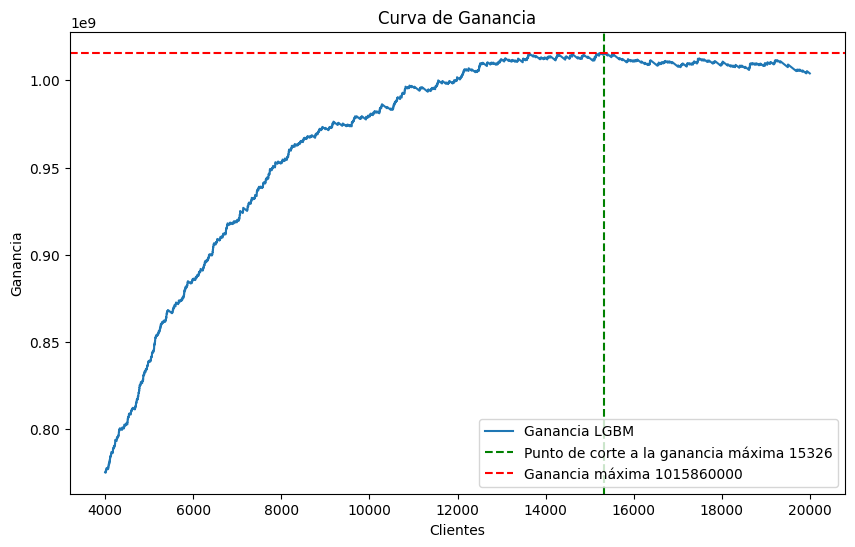

In [24]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)
idx = np.argsort(y_pred_lgm)[::-1]
ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]
ganancia_cum = np.cumsum(ganancia)
piso_envios = 4000
techo_envios = 20000


ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

